In [4]:
from bs4 import BeautifulSoup
from selenium import webdriver
import	requests
from urllib.request import urlopen
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np
import pandas as pd
import koreanize_matplotlib
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import time
from PIL import Image
import platform

In [89]:
def get_links(link_list, name_list, career_list, education_list,worker_list ,city_list):
    '''
    잡코리아 링크 가져오는 함수
    parms= 링크 모아놓을 빈 리스트
    return
    '''
    num=1
    regions = ["서울","도쿄", "부산", "대구", "인천", "광주", "대전", "울산", "세종", "경기", "강원", "충북", "충남", "전북", "전남", "경북", "경남", "제주"]
    workers = ["정규직","계약직","인턴","파견직","도급","프리랜서","아르바이트","연수생/교육생","병역특례","위촉직/개인사업자"]
    while num<=130:
        url= urlopen(f'https://www.jobkorea.co.kr/Search/?stext=java&tabType=recruit&Page_No={num}')
        soup= BeautifulSoup(url, 'html.parser')

        links= soup.find_all('a', {'class': "corp-name-link dev-view"})
        for link in links:
            link= link['href']
            link_list.append(link)
        for name in links:
            name= name['title']
            name_list.append(name)
        
        links= soup.find_all('ul', {'class': "chip-inormation-group"})
        for i in range(20):
            li_items = links[i].find_all('li')
            career = None
            education = None
            city = None
            worker_type = None

            for item in li_items:
                text = item.text
                if "경력" in text or "신입" in text:  # 경력
                    career= text
                elif "졸" in text or "무관" in text:  # 학력 
                    education = text
                elif any(worker in text for worker in workers):
                    worker_type = text
                elif any(region in text for region in regions):  # 지역 리스트에 포함된 지역만 추가
                    city = text
                
            career_list.append(career if career else 'null')
            education_list.append(education if education else 'null')
            worker_list.append(worker_type if worker_type else 'null')
            city_list.append(city if city else 'null')
                
        num+=1

In [90]:
link_list=[]
name_list=[]
career_list = []
education_list = []
worker_list = []
city_list = []
get_links(link_list, name_list, career_list, education_list, worker_list, city_list)

In [168]:
print(len(link_list),len(name_list),len(career_list),len(education_list),len(city_list),len(worker_list))

2600 2600 2600 2600 2600 2600


In [169]:
data ={'name': name_list,
       'link': link_list,
       'career': career_list,
       'education': education_list,
       'worker' : worker_list,
       'city':city_list}

In [336]:
df = pd.DataFrame(data)

In [94]:
# df.to_csv('jobkorea.csv', index=False, encoding='utf-8-sig')
# print('jobkorea.csv 파일 저장완료.')

jobkorea.csv 파일 저장완료.


In [5]:
df=pd.read_csv(r'C:\Users\KDP15\Desktop\KDT6\크롤링\미니프로젝트\jobkorea.csv')

In [6]:
new_df = df.replace('null', pd.NA).dropna()
new_df = new_df[new_df['worker'] != '연수생/교육생']

In [7]:
text_data = df.drop(columns=['link']).apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
combined_text = ' '.join(text_data)


In [8]:
okt = Okt()
tokens = okt.nouns(combined_text)
korean_text = ' '.join(tokens)

In [9]:
wordcloud = WordCloud(font_path=r'c\Windows\Fonts\malgun.ttf',width=800, height=400, background_color='white').generate(combined_text)

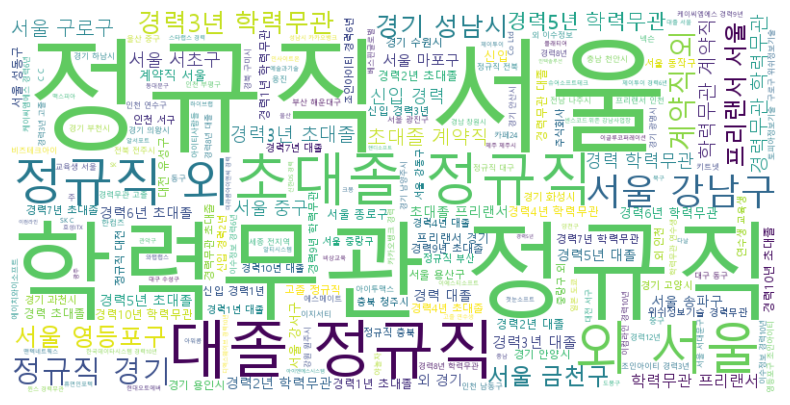

In [10]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
new_df['city'] = new_df['city'].str[:2]

In [12]:
new_df['career'] =new_df['career'].str.replace('년', '')

In [13]:
top10 = new_df['name'].value_counts().head(10)

In [14]:
companies = top10.index
counts = top10.values

In [15]:
colors = [
    "#AED6F1",  # 옅은 하늘색
    "#A9DFBF",  # 옅은 초록색
    "#F9E79F",  # 옅은 노란색
    "#F5B7B1",  # 옅은 핑크색
    "#D2B4DE",  # 옅은 보라색
    "#FAD7A0",  # 옅은 주황색
    "#D5DBDB",  # 옅은 회색
    "#A3E4D7",  # 옅은 민트색
    "#D7BDE2",  # 옅은 연보라색
    "#F5CBA7",  # 옅은 살구색
]


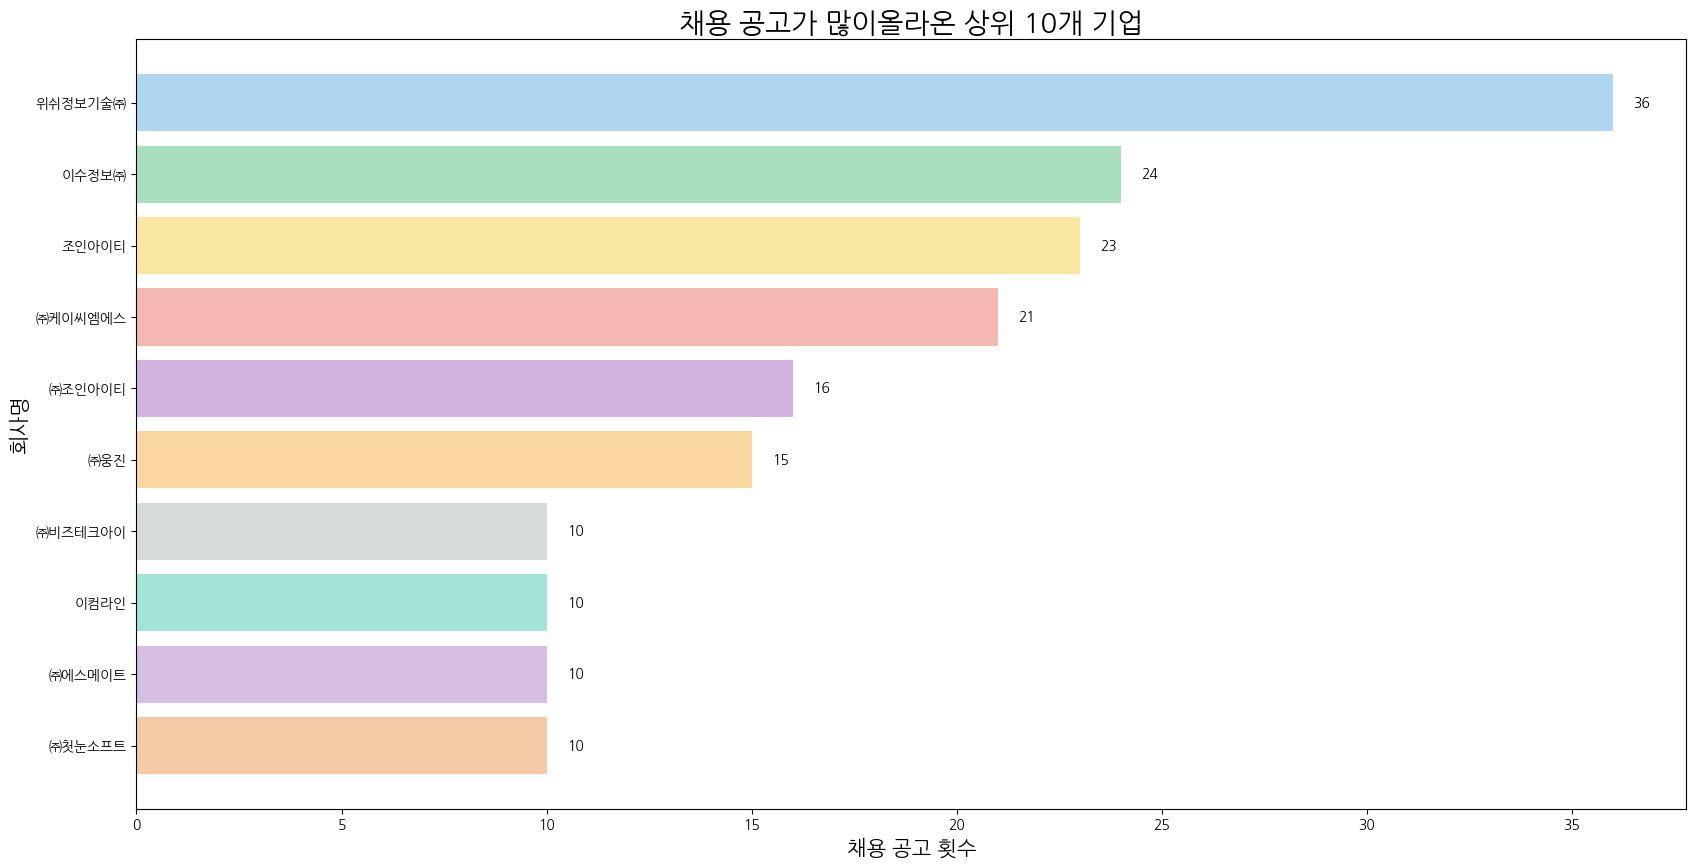

In [16]:
plt.figure(figsize=(20,10))
bars = plt.barh(companies, counts, color=colors)
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left')
    
plt.title('채용 공고가 많이올라온 상위 10개 기업', fontsize = 20)
plt.ylabel('회사명',fontsize=15)
plt.xlabel('채용 공고 횟수', fontsize=15)
plt.gca().invert_yaxis() # y축 반전
plt.show()

In [17]:
education_counts = new_df['education'].value_counts()

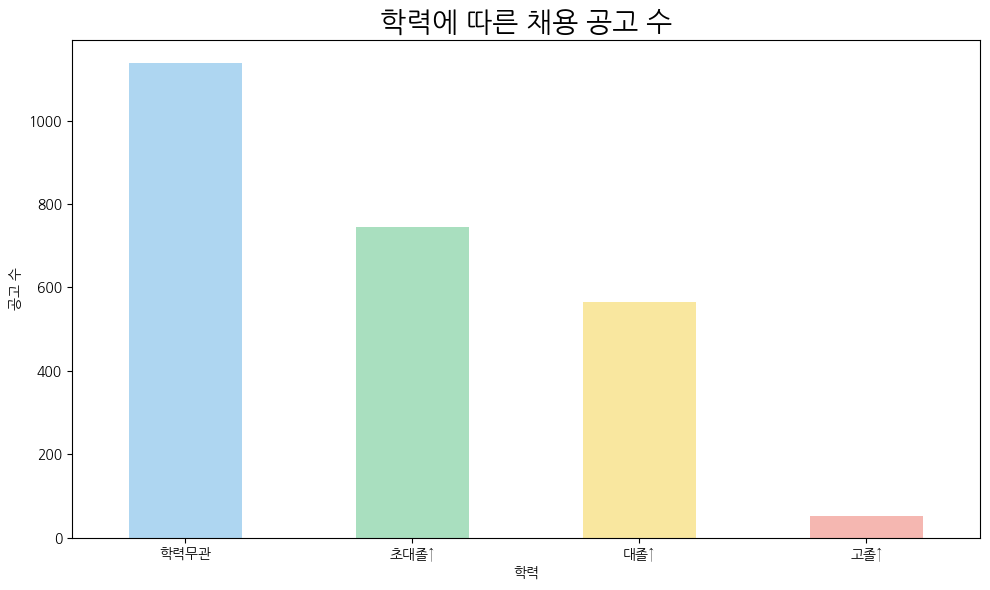

In [18]:
plt.figure(figsize=(10, 6))
education_counts.plot(kind='bar', color= colors)
plt.xticks(rotation=360)
plt.xlabel('학력')
plt.ylabel('공고 수')
plt.title('학력에 따른 채용 공고 수',fontsize=20)
plt.tight_layout()
plt.show()

In [19]:
city_counts = new_df['city'].value_counts()

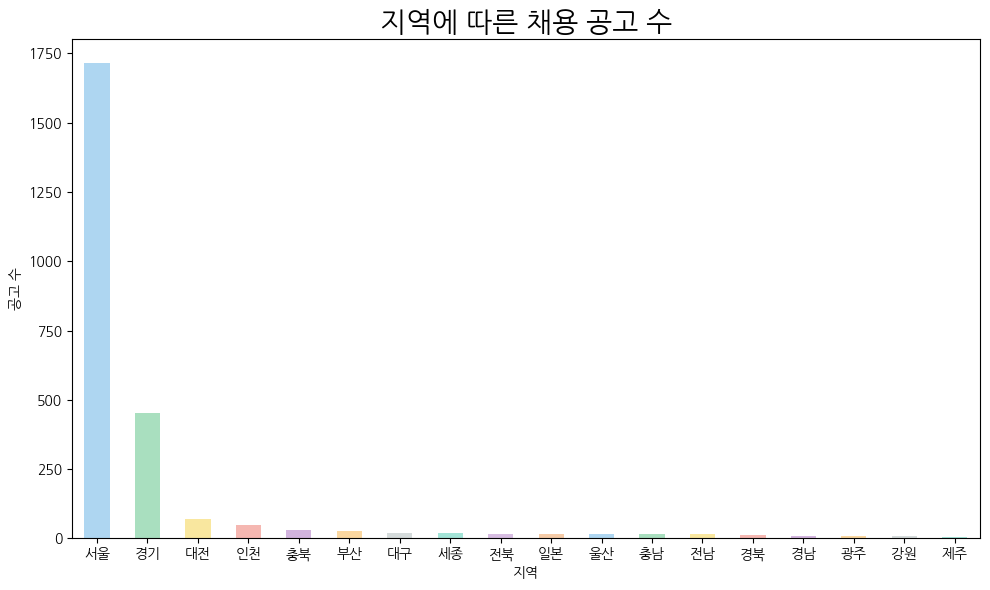

In [20]:
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color=colors)
plt.xticks(rotation=360)
plt.xlabel('지역')
plt.ylabel('공고 수')
plt.title('지역에 따른 채용 공고 수',fontsize=20)
plt.tight_layout()
plt.show()

In [21]:
new_df.groupby('city').count()['name']

city
강원       7
경기     454
경남       9
경북      12
광주       8
대구      21
대전      68
부산      28
서울    1715
세종      18
울산      15
인천      49
일본      16
전남      14
전북      16
제주       6
충남      15
충북      30
Name: name, dtype: int64

In [22]:
new_df['city'] = new_df['city'].apply(lambda x: x if x in ['서울', '경기', '대구', '일본'] else '기타')

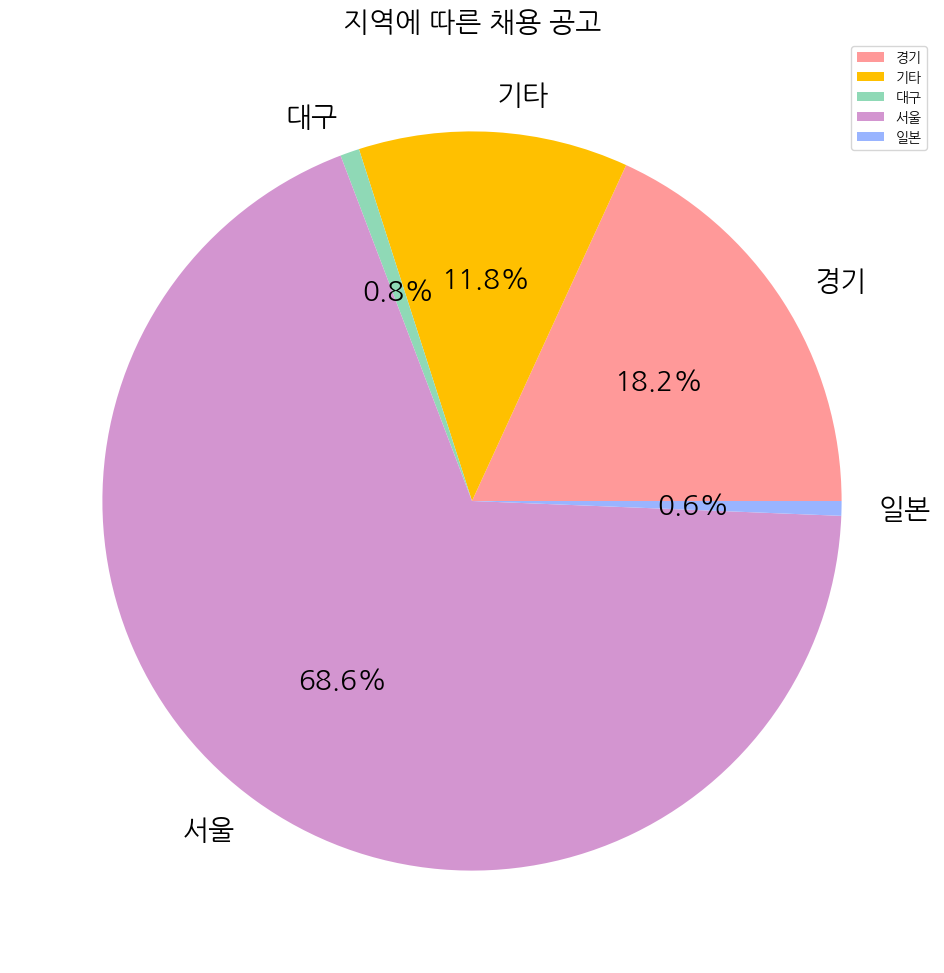

In [28]:
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#99b4ff']

plt.figure(figsize=(12, 12))
plt.pie(new_df.groupby('city').count()['name'], labels=new_df.groupby('city').count()['name'].index,autopct='%1.1f%%', colors=colors,textprops={'fontsize': 20})
plt.title('지역에 따른 채용 공고',fontsize=20)
plt.legend()
plt.show()

In [29]:
new_df['worker'].value_counts().index

Index(['정규직', '정규직 외', '계약직 외', '프리랜서', '계약직', '프리랜서 외', '인턴', '도급 외', '파견직',
       '병역특례'],
      dtype='object', name='worker')

In [30]:
worker = new_df['worker'].value_counts().index
counts = new_df['worker'].value_counts().values

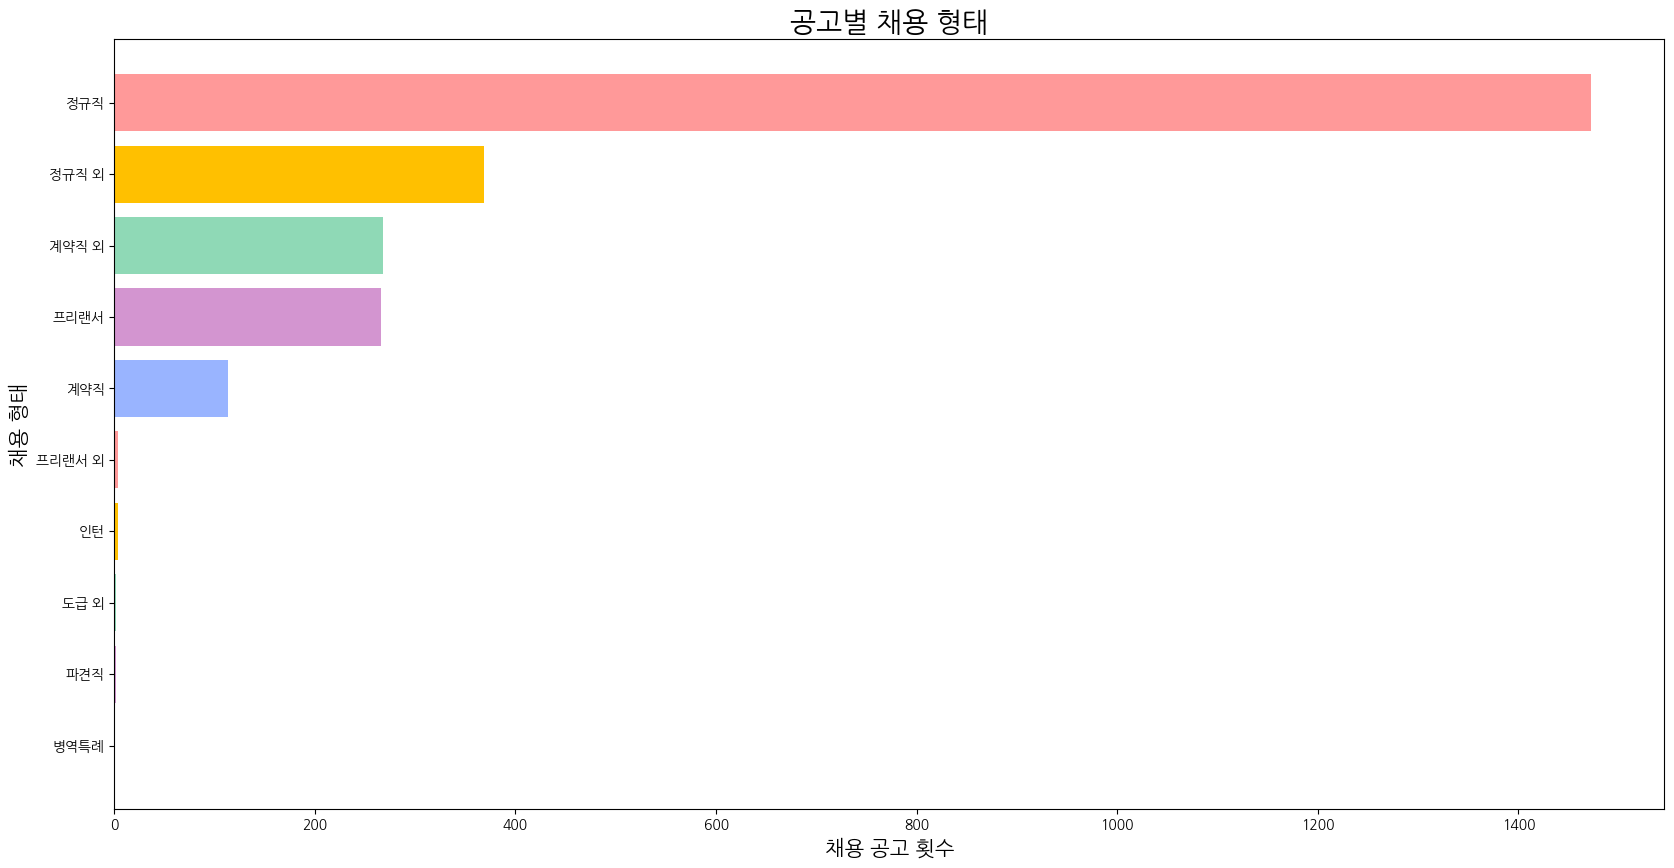

In [36]:
plt.figure(figsize=(20,10))
plt.barh(worker, counts, color=colors)
   
plt.title('공고별 채용 형태', fontsize = 20)
plt.ylabel('채용 형태',fontsize=15)
plt.xlabel('채용 공고 횟수', fontsize=15)
plt.gca().invert_yaxis() # y축 반전
plt.show()

In [32]:
def rename_career(x):
    if '신입·경력' in x:
        return '신입·경력'
    elif x in ['신입', '경력무관']:
        return x
    else:
        return '경력'

In [33]:
new_career_df = new_df['career'].apply(rename_career)

In [34]:
career_counts = new_career_df.value_counts()

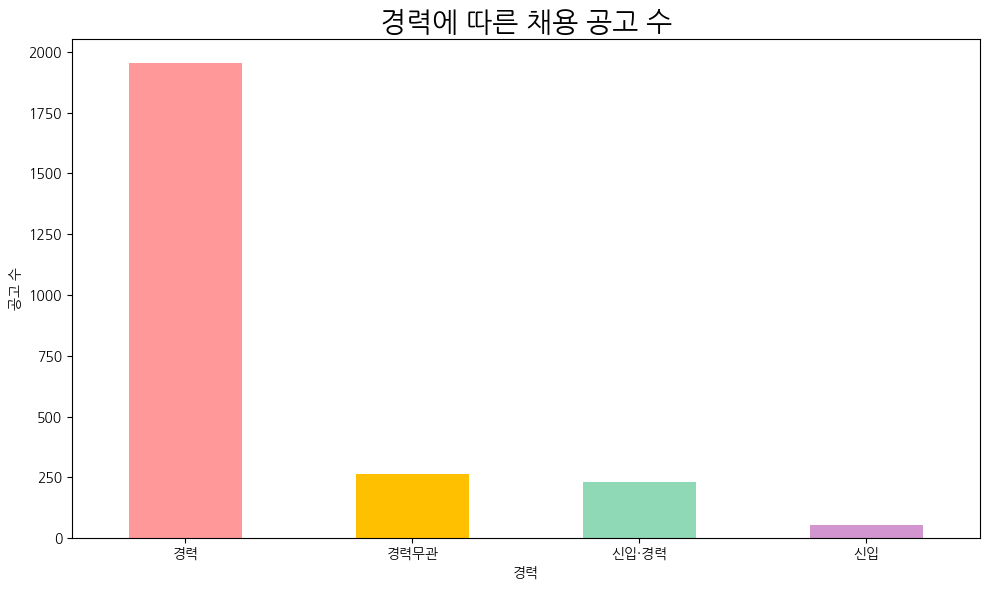

In [37]:
plt.figure(figsize=(10, 6))
career_counts.plot(kind='bar',color=colors)
plt.xticks(rotation=360)
plt.xlabel('경력')
plt.ylabel('공고 수')
plt.title('경력에 따른 채용 공고 수',fontsize=20)
plt.tight_layout()
plt.show()